In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.feather as feather
import os
import random

In [3]:
parent_folder = os.path.dirname(os.getcwd())
sibling_folder = os.path.join(parent_folder,'data')
processed_folder = os.path.join(sibling_folder, 'processed')

In [5]:
feather_file_path = os.path.join(processed_folder, 'icu_timeseries_features_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather')
df = feather.read_feather(feather_file_path)
df = df[['abs_event_time', 'stay_id','O2 saturation pulseoxymetry','Arterial Blood Pressure mean','Bilirubin, Total','Platelet Count','Creatinine','GCS - Eye Opening','GCS - Motor Response','GCS - Verbal Response']]
df['abs_event_time'] = pd.to_datetime(df['abs_event_time'])

In [6]:
calculate_SOFA = lambda SpO2, gcs_eye_opening, gcs_motor_response, gcs_verbal_response, platelet_count, bilirubin, mean_arterial_pressure, creatinine: (
    # Respiratory component
    4 if SpO2 < 90 else
    3 if SpO2 < 92 else
    2 if SpO2 < 94 else
    1 if SpO2 < 96 else
    0
) + (
    # Cardiovascular component (MAP)
    4 if mean_arterial_pressure < 40 else
    3 if mean_arterial_pressure < 50 else
    2 if mean_arterial_pressure < 60 else
    1 if mean_arterial_pressure < 70 else
    0
) + (
    # Liver component
    4 if bilirubin >= 12.0 else
    3 if bilirubin >= 6.0 else
    2 if bilirubin >= 2.0 else
    1 if bilirubin >= 1.2 else
    0
) + (
    # Coagulation component
    4 if platelet_count <= 20 else
    3 if platelet_count <= 50 else
    2 if platelet_count <= 100 else
    1 if platelet_count <= 150 else
    0
) + (
    # Renal component
    4 if creatinine > 5 else
    3 if 3.5 <= creatinine <= 4.9 else
    2 if 2.0 <= creatinine <= 3.4 else
    1 if 1.2 <= creatinine <= 1.9 else
    0
) + (
    # Glasgow Coma Scale
    4 if gcs_eye_opening + gcs_motor_response + gcs_verbal_response < 6 else
    3 if gcs_eye_opening + gcs_motor_response + gcs_verbal_response < 10 else
    2 if gcs_eye_opening + gcs_motor_response + gcs_verbal_response < 13 else
    1 if gcs_eye_opening + gcs_motor_response + gcs_verbal_response < 15 else
    0
)


In [18]:
df_ffilled = df.ffill()
df_filled = df_ffilled.bfill()
df_filled['SOFA_score'] = df_filled.apply(lambda row: calculate_SOFA(row['O2 saturation pulseoxymetry'], row['GCS - Eye Opening'], row['GCS - Motor Response'], row['GCS - Verbal Response'], row['Platelet Count'], row['Bilirubin, Total'], row['Arterial Blood Pressure mean'], row['Creatinine']), axis=1)

In [21]:
low_threshold = 10
high_threshold = 22
random_stay_id = random.choice(df_filled['stay_id'])
filtered_df = df_filled[df_filled['stay_id'] == random_stay_id]
filtered_df_copy = filtered_df.copy()
bins = [-float('inf'), low_threshold, high_threshold, float('inf')]
labels = ['Low', 'Moderate', 'High']
filtered_df_copy.loc[:, 'score_category'] = pd.cut(filtered_df_copy['SOFA_score'], bins=bins, labels=labels, right=False)

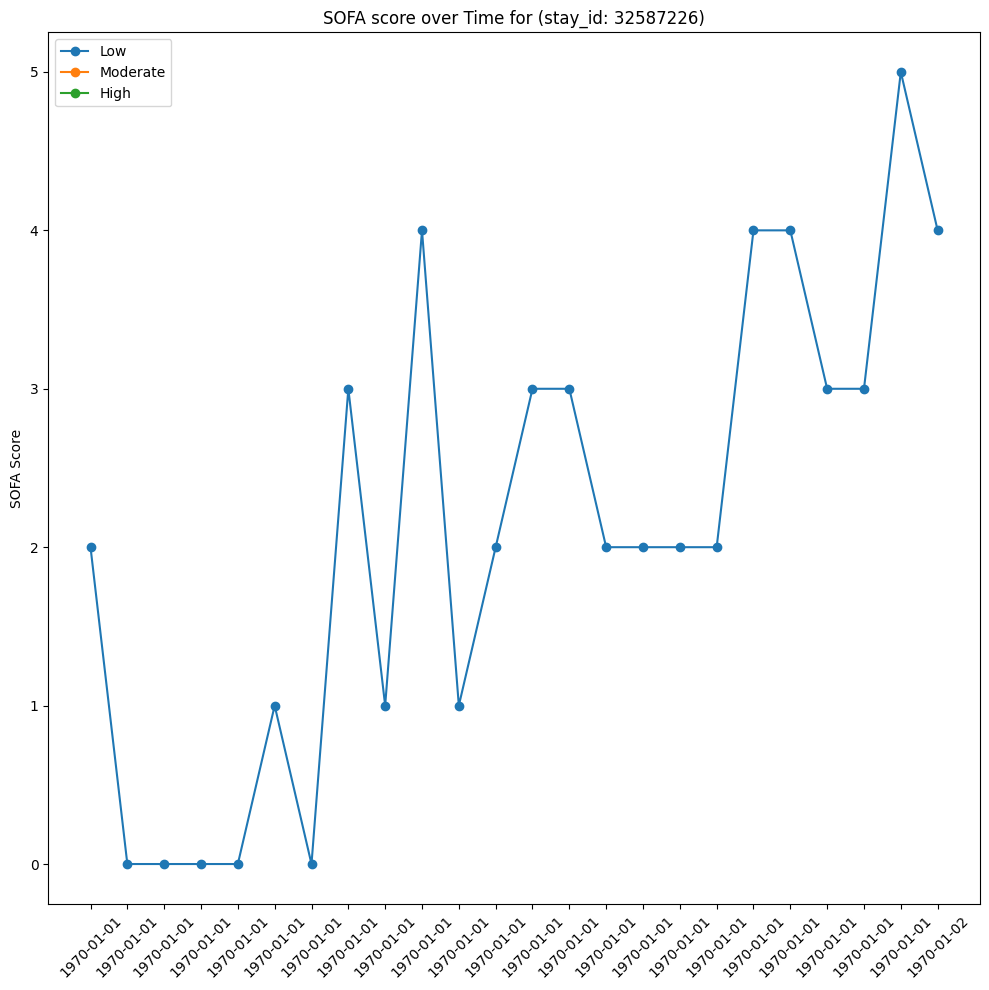

In [22]:
plt.figure(figsize=(10, 10))
for category, group in filtered_df_copy.groupby('score_category', observed=False):
    plt.plot(group['abs_event_time'], group['SOFA_score'], marker='o', linestyle='-', label=category)
plt.ylabel('SOFA Score')
plt.title('SOFA score over Time for (stay_id: {})'.format(random_stay_id))
plt.legend()  
plt.xticks(filtered_df_copy['abs_event_time'], rotation=45)
plt.tight_layout() 
plt.show()